# Q Learning

In [1]:
import gym
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print ("plt version:[%s]"%(matplotlib.__version__))
print ("gym version:[%s]"%(gym.__version__))

plt version:[3.3.4]
gym version:[0.18.0]


##### Helper functions

In [2]:
def display_q_value(Q, title="Q Function",fig_size=8,text_fs=9,title_fs=15):
    """
    Display Q value
    """
    n_state, n_action = Q.shape
    nRow = 8
    # Triangle patches for each action
    lft_tri = np.array([[0,0],[-0.5,-0.5],[-0.5,0.5]])
    dw_tri = np.array([[0,0],[-0.5,0.5],[0.5,0.5]])
    up_tri = np.array([[0,0],[0.5,-0.5],[-0.5,-0.5]])
    rgh_tri = np.array([[0,0],[0.5,0.5],[0.5,-0.5]])
    # Color
    high_color = np.array([1.0, 0.0, 0.0, 0.8])
    low_color  = np.array([1.0, 1.0, 1.0, 0.8])
    fig = plt.figure(figsize=(fig_size,fig_size))
    plt.title(title,fontsize=title_fs)  
    for i in range(nRow):
        for j in range(nRow):
            s = i*nRow+j
            min_q = np.min(Q[s])
            max_q = np.max(Q[s])
            for a in range(n_action):
                q_value = Q[s,a]
                ratio = (q_value - min_q)/(max_q - min_q + 1e-10) 
                if ratio > 1: clr = high_color
                elif ratio < 0: clr = low_color
                else: clr = high_color*ratio + low_color*(1-ratio)
                if a == 0: # Left arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+lft_tri, color=clr, ec='k'))
                    plt.text(j-0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 1: # Down arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+dw_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i+0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 2: # Right arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+rgh_tri, color=clr, ec='k'))
                    plt.text(j+0.25, i+0.0,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
                if a == 3: # Up arrow
                    plt.gca().add_patch(plt.Polygon([j,i]+up_tri, color=clr, ec='k'))
                    plt.text(j-0.0, i-0.25,"%.2f"%(q_value),fontsize=text_fs,va='center', ha='center')
    plt.xlim([-0.5,nRow-0.5])
    plt.xticks(range(nRow))
    plt.ylim([-0.5,nRow-0.5])
    plt.yticks(range(nRow))
    plt.gca().invert_yaxis()
    plt.show()
    
def visualize_matrix(M,strs='',fontsize=15,cmap='turbo',title='Title',title_fs=15,
                     fig_size=8,REMOVE_TICK_LABELS=True):
    """
    Visualize a matrix colors and strings 
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    n_row,n_col = M.shape[0],M.shape[1]
    fig,ax = plt.subplots(figsize=(fig_size,fig_size))
    divider = make_axes_locatable(ax)
    im = ax.imshow(M,cmap=plt.get_cmap(cmap),extent=(0,n_col,n_row,0),
              interpolation='nearest',aspect='equal')
    ax.set_xticks(np.arange(0,n_col,1))
    ax.set_yticks(np.arange(0,n_row,1))
    ax.grid(color='w', linewidth=2)
    ax.set_frame_on(False)
    x,y = np.meshgrid(np.arange(0,n_col,1.0),np.arange(0,n_row,1.0))
    if len(strs) == n_row*n_col:
        idx = 0
        for x_val,y_val in zip(x.flatten(), y.flatten()):
            c = strs[idx]
            idx = idx + 1
            ax.text(x_val+0.5,y_val+0.5,c,va='center', ha='center',size=fontsize)
    cax = divider.append_axes('right', size='5%', pad=0.05)            
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.suptitle(title,size=title_fs) 
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    if REMOVE_TICK_LABELS:
        plt.setp(ax.get_xticklabels(),visible=False)
        plt.setp(ax.get_yticklabels(),visible=False)
    plt.show()
    
print ("Done")    

Done


### Q Learning
To implement model-free policy iteration, we need to estimate the followings using samples:

$Q_{k+1}(s,a) = \sum_{s'} \left[r(s,a,s') + \gamma \max_{a'} Q_{k}(s',a') \right] P(s'|s,a)$

Update Q value using temporal difference (TD) target and error:

$Q_{new}(S_{t}, A_{t}) \leftarrow Q_{old}(S_{t}, A_{t}) + \alpha (R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q_{old}(S_{t}, A_{t}))$

We can update our estimator online, just $(S_{t},A_{t},R_{t+1},S_{t+1})$ is needed.
$A_{t+1}$ is not needed.

TD target is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a')$

TD error is $R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q(S_{t},A_{t})$

Algorithm
--
---
For every time step

Policy Evaluation

- Collect $(S_{t},A_{t},R_{t+1},S_{t+1})$

- $\text{TD target} = R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a')$

- $\text{TD error} = R_{t+1} + \gamma \max_{a'} Q_{old}(S_{t+1},a') - Q(S_{t},A_{t})$

- $Q[S_{t}, A_{t}] = Q[S_{t}, A_{t}] + \alpha \text{TD target}$

Policy Improvement

- $\pi(a|s) = \frac{\epsilon}{m} + (1-\epsilon) \mathbf{1}\left(a = \max_{a'} Q(s,a')\right)$

In [3]:
class Q_learningAgent():
    def __init__(self,n_state,n_action,alpha=0.5,epsilon=1.0,gamma=0.999):
        self.n_state = n_state
        self.n_action = n_action
        self.alpha_init = alpha
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        
        # Initial Q value
        self.Q = np.zeros([n_state,n_action])
        
    def update_value(self,state,action,reward,state_prime,done):
        """
        Update value
        """
        Q_old = self.Q[state][action]
        # TD target
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma*np.max(self.Q[state_prime])
        td_error = td_target - Q_old # TD error
        self.Q[state,action] = Q_old + self.alpha*td_error # update Q
        
    def update_epsilon(self,epsilon):
        self.epsilon = np.min([epsilon,1.0]) 
        
    def update_alpha(self,alpha):
        self.alpha = np.min([alpha,self.alpha_init]) 
        
    def get_action(self,state):
        """
        Get action
        """
        if np.random.uniform() < self.epsilon:
            action = np.random.randint(0,high=self.n_action)
        else:
            action = np.argmax(self.Q[state])
        return action 
        
print ("Done.")        

Done.


### Run Q learning agent (with random policy) 
3,000 episodes

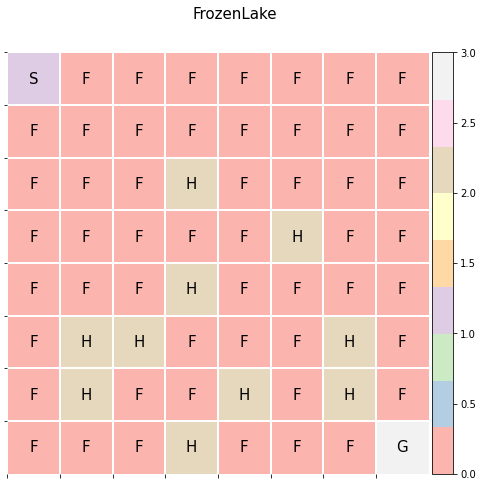

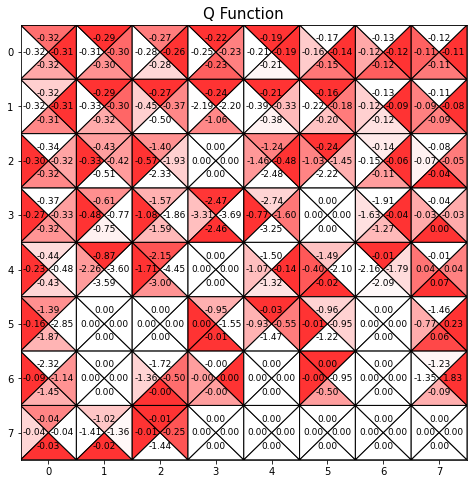

Done.


In [4]:
env = gym.make('FrozenLake8x8-v0')
n_state = env.observation_space.n
n_action = env.action_space.n
# epsilon=1.0 -> random policy
Q = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)
# Loop 
n_episode = 3000
for e_idx in range(n_episode):
    state = env.reset()
    action = Q.get_action(state)
    done = False
    while not done:
        state_prime, reward, done, info = env.step(action)
        if done:
            # Reward modification to handle sparse reward
            if reward == 0:  reward = -5 # let hole to have -1 reward
            else: reward = +10 # let goal to have +10 reward
        else:
            reward = -0.01
        action_prime = Q.get_action(state_prime)
        Q.update_value(state, action, reward, state_prime, done)
        state = state_prime
        action = action_prime
        
    # Q.update_epsilon(1000/(e_idx+1)) # reduce randomness
    Q.update_alpha(1000/(e_idx+1)) # reduce update rate
# Plot env
E = np.zeros(shape=(8,8))
strs = ['S','F','F','F','F','F','F','F',
       'F','F','F','F','F','F','F','F',
       'F','F','F','H','F','F','F','F',
       'F','F','F','F','F','H','F','F',
       'F','F','F','H','F','F','F','F',
       'F','H','H','F','F','F','H','F',
       'F','H','F','F','H','F','H','F',
       'F','F','F','H','F','F','F','G']
E[0,0] = 1 # Start
E[2,3]=E[3,5]=E[4,3]=E[5,1]=E[5,2]=E[5,6]=E[6,1]=E[6,4]=E[6,6]=E[7,3]=2 # Hole
E[7,7] = 3 # Goal
visualize_matrix(E,strs=strs,cmap='Pastel1',title='FrozenLake',fig_size=7)
display_q_value(Q.Q,title="Q Function",
                fig_size=8,text_fs=9,title_fs=15)    
print ("Done.")

### Run Q learning agent (with random policy) 
10,000 episodes

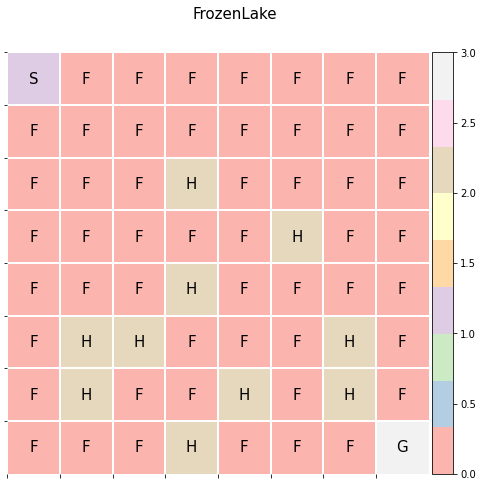

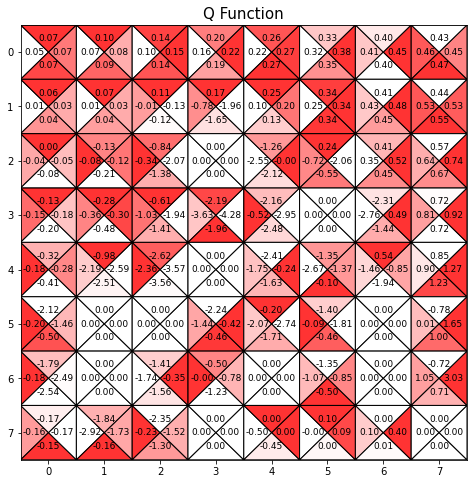

Done.


In [5]:
env = gym.make('FrozenLake8x8-v0')
n_state = env.observation_space.n
n_action = env.action_space.n
# epsilon=1.0 -> random policy
Q = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)
# Loop 
n_episode = 10000
for e_idx in range(n_episode):
    state = env.reset()
    action = Q.get_action(state)
    done = False
    while not done:
        state_prime, reward, done, info = env.step(action)
        if done:
            # Reward modification to handle sparse reward
            if reward == 0:  reward = -5 # let hole to have -1 reward
            else: reward = +10 # let goal to have +10 reward
        else:
            reward = -0.01
        action_prime = Q.get_action(state_prime)
        Q.update_value(state, action, reward, state_prime, done)
        state = state_prime
        action = action_prime
        
    # Q.update_epsilon(1000/(e_idx+1)) # reduce randomness
    Q.update_alpha(1000/(e_idx+1)) # reduce update rate
# Plot env
visualize_matrix(E,strs=strs,cmap='Pastel1',title='FrozenLake',fig_size=7)
display_q_value(Q.Q,title="Q Function",
                fig_size=8,text_fs=9,title_fs=15)    
print ("Done.")

### Run Q learning agent (with $\epsilon$-greedy) 
3,000 episodes

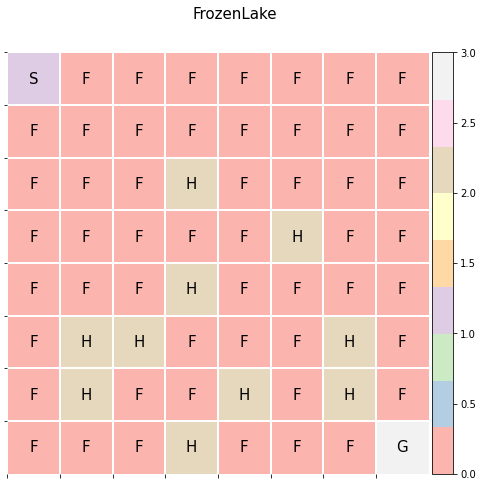

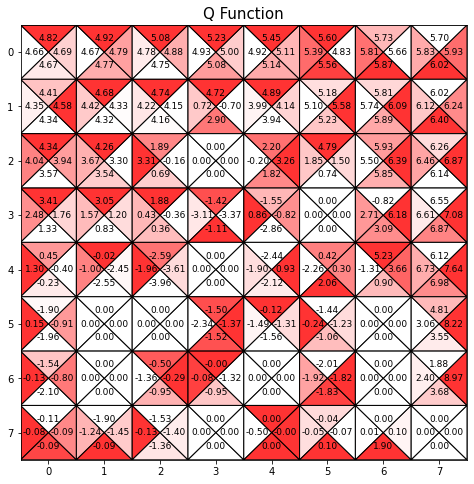

Done.


In [6]:
env = gym.make('FrozenLake8x8-v0')
n_state = env.observation_space.n
n_action = env.action_space.n
# epsilon=1.0 -> random policy
Q = Q_learningAgent(n_state,n_action,epsilon=1.0,alpha=0.1,gamma=0.999)
# Loop 
n_episode = 3000
for e_idx in range(n_episode):
    state = env.reset()
    action = Q.get_action(state)
    done = False
    while not done:
        state_prime, reward, done, info = env.step(action)
        if done:
            # Reward modification to handle sparse reward
            if reward == 0:  reward = -5 # let hole to have -1 reward
            else: reward = +10 # let goal to have +10 reward
        else:
            reward = -0.01
        action_prime = Q.get_action(state_prime)
        Q.update_value(state, action, reward, state_prime, done)
        state = state_prime
        action = action_prime
        
    Q.update_epsilon(1000/(e_idx+1)) # reduce randomness
    # Q.update_alpha(1000/(e_idx+1)) # reduce update rate

# Plot
visualize_matrix(E,strs=strs,cmap='Pastel1',title='FrozenLake',fig_size=7)
display_q_value(Q.Q,title="Q Function",
                fig_size=8,text_fs=9,title_fs=15)
print ("Done.")